<a href="https://colab.research.google.com/github/RyanValenzuela-Porta/WarwickAI_Trading_Project/blob/main/regression_model_for_all_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=aa44b217c21ec379bde62a05bf6f1b502c6ddb35a5fd1d2878ea80f4bcb89722
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [9]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


In [10]:
import yfinance as yf
import pandas as pd

def fetch_data(tickers, start_date, end_date):
    """
    Fetch stock data from yfinance for given tickers and date range.

    Args:
        tickers (list): List of stock ticker symbols (e.g., ["AAPL", "MSFT"]).
        start_date (str): Start date in the format "YYYY-MM-DD".
        end_date (str): End date in the format "YYYY-MM-DD".

    Returns:
        pd.DataFrame: A two-way DataFrame indexed by date and stock ticker.
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

    # Prepare a two-way DataFrame with MultiIndex
    frames = []
    for ticker in tickers:
        stock_data = data[ticker].dropna()
        stock_data['Ticker'] = ticker
        frames.append(stock_data)

    combined_data = pd.concat(frames)
    combined_data.index.names = ['Date']
    combined_data.reset_index(inplace=True)
    multi_index_df = combined_data.set_index(['Date', 'Ticker'])

    return multi_index_df

# Demonstrate usage with AAPL, MSFT, NVDA and the specified date range
tickers = ['BRKB','AAPL']
start_date = "2023-01-01"
end_date = "2024-11-01"

data = fetch_data(tickers, start_date, end_date)
print("Two-way indexed DataFrame (sample):")
print(data.head())

# Access all data for the last 5 days in the DataFrame
last_5_days = data.loc[data.index.get_level_values('Date')[-5:]]
print("\nData for the last 5 days:")
print(last_5_days)

# Access all data for a specific stock, e.g., AAPL
aapl_data = data.xs('AAPL', level='Ticker')
print("\nData for AAPL:")
print(aapl_data)


[*********************100%***********************]  2 of 2 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRKB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Two-way indexed DataFrame (sample):
Price                    Open        High         Low       Close   Adj Close  \
Date       Ticker                                                               
2023-01-03 AAPL    130.279999  130.899994  124.169998  125.070000  123.768456   
2023-01-04 AAPL    126.889999  128.660004  125.080002  126.360001  125.045044   
2023-01-05 AAPL    127.129997  127.769997  124.760002  125.019997  123.718979   
2023-01-06 AAPL    126.010002  130.289993  124.889999  129.619995  128.271072   
2023-01-09 AAPL    130.470001  133.410004  129.889999  130.149994  128.795593   

Price                   Volume  
Date       Ticker               
2023-01-03 AAPL    112117500.0  
2023-01-04 AAPL     89113600.0  
2023-01-05 AAPL     80962700.0  
2023-01-06 AAPL     87754700.0  
2023-01-09 AAPL     70790800.0  

Data for the last 5 days:
Price                    Open        High         Low       Close   Adj Close  \
Date       Ticker                                        

In [11]:

import pandas_ta as ta

def add_technical_indicators_with_look_forward(data):
    """
    Adds technical indicators and a look-forward percentage change (future_pct_change_21d) to the stock data.

    Args:
        data (pd.DataFrame): MultiIndex DataFrame indexed by Date and Ticker containing stock data.

    Returns:
        pd.DataFrame: Modified DataFrame with added technical indicator features and look-forward target.
    """
    # Reset the index for easier manipulation
    data = data.reset_index()

    # Group by each stock ticker and calculate technical indicators
    indicators = []
    for ticker, group in data.groupby("Ticker"):
        group.set_index("Date", inplace=True)

        # Add technical indicators
        group['rsi'] = ta.rsi(group['Close'], length=14)         # RSI
        group['momentum'] = ta.mom(group['Close'], length=10)    # Momentum
        group['sma_50'] = ta.sma(group['Close'], length=50)      # 50-day Simple Moving Average

        # Add look-forward target
        group['future_pct_change_21d'] = group['Close'].pct_change(21).shift(-21)  # 21-day forward return

        indicators.append(group)

    # Combine the processed groups
    enhanced_data = pd.concat(indicators)

    # Restore MultiIndex
    enhanced_data = enhanced_data.reset_index().set_index(['Date', 'Ticker'])

    return enhanced_data
tickers = ["AAPL", "MSFT", "NVDA"]
start_date = "2023-01-01"
end_date = "2024-11-01"

data = fetch_data(tickers, start_date, end_date)
print("Original DataFrame (sample):")
print(data.head())

enhanced_data = add_technical_indicators_with_look_forward(data)
print("\nEnhanced DataFrame (sample):")
print(enhanced_data.tail())

[*********************100%***********************]  3 of 3 completed

Original DataFrame (sample):
Price                    Open        High         Low       Close   Adj Close  \
Date       Ticker                                                               
2023-01-03 AAPL    130.279999  130.899994  124.169998  125.070000  123.768456   
2023-01-04 AAPL    126.889999  128.660004  125.080002  126.360001  125.045044   
2023-01-05 AAPL    127.129997  127.769997  124.760002  125.019997  123.718979   
2023-01-06 AAPL    126.010002  130.289993  124.889999  129.619995  128.271072   
2023-01-09 AAPL    130.470001  133.410004  129.889999  130.149994  128.795593   

Price                 Volume  
Date       Ticker             
2023-01-03 AAPL    112117500  
2023-01-04 AAPL     89113600  
2023-01-05 AAPL     80962700  
2023-01-06 AAPL     87754700  
2023-01-09 AAPL     70790800  

Enhanced DataFrame (sample):
Price                    Open        High         Low       Close   Adj Close  \
Date       Ticker                                                          

In [12]:
from sklearn.metrics import mean_squared_error

def train_xgboost_per_stock_with_lookforward(data):
    """
    Trains an XGBoost Regressor for each stock individually using look-forward data and makes predictions.

    Args:
        data (pd.DataFrame): Enhanced stock data with technical indicators and future percentage change target.

    Returns:
        dict: Dictionary with tickers as keys and DataFrames containing predictions, actual values, and models.
    """
    # Reset the index for easier processing
    data = data.reset_index()
    stock_predictions = {}
    stock_models = {}

    for ticker, group in data.groupby("Ticker"):
        print(f"Training model for stock: {ticker}")

        # Prepare data for the current stock
        group = group.dropna()  # Remove rows with NaN values

        # Include 'Date' in the features temporarily for indexing later
        X = group[['rsi', 'momentum', 'sma_50']].copy()
        X['Date'] = group['Date']
        y = group['future_pct_change_21d']  # Target (future 21-day percentage change)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Save the corresponding dates from X_test
        test_dates = X_test['Date']
        X_train = X_train.drop(columns=['Date'])
        X_test = X_test.drop(columns=['Date'])

        # Initialize and train the XGBoost regressor
        model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_pred)

        # Store the predictions, actual values, and model in the dictionary
        predictions_df = pd.DataFrame({
            'Date': test_dates.values,  # Dates from the test set
            'Predicted': y_pred,
            'Actual': y_test.values
        })
        predictions_df.set_index('Date', inplace=True)

        stock_predictions[ticker] = predictions_df
        stock_models[ticker] = {
            'model': model,
            'mse': mse
        }

    return stock_predictions, stock_models
# data = fetch_data(['AAPL', 'MSFT', 'NVDA'], '2023-01-01', '2024-11-01')
# enhanced_data = add_technical_indicators_with_look_forward(data)

# # Train models and get predictions for each stock
# stock_predictions,stock_models = train_xgboost_per_stock_with_lookforward(enhanced_data)

# for ticker, predictions in stock_predictions.items():
#     # Sort by the Date index
#     stock_predictions[ticker] = predictions.sort_index()

# # Display results for each stock
# for ticker, predictions in stock_predictions.items():
#     print(f"\nPredictions for {ticker}:")
#     print(predictions.tail())

[*********************100%***********************]  3 of 3 completed


Training model for stock: AAPL
Training model for stock: MSFT
Training model for stock: NVDA

Predictions for AAPL:
            Predicted    Actual
Date                           
2024-08-30   0.016703 -0.012183
2024-09-04   0.022048  0.021825
2024-09-09   0.034004  0.022000
2024-09-17   0.044175  0.069145
2024-09-20   0.021343  0.036284

Predictions for MSFT:
            Predicted    Actual
Date                           
2024-08-30   0.000861  0.008510
2024-09-04   0.017875  0.018684
2024-09-09   0.020267  0.022158
2024-09-17  -0.042602 -0.043732
2024-09-20  -0.024612 -0.037885

Predictions for NVDA:
            Predicted    Actual
Date                           
2024-08-30   0.016999 -0.019854
2024-09-04   0.155596  0.156671
2024-09-09   0.106193  0.248145
2024-09-17   0.197516  0.174150
2024-09-20   0.207270  0.238879


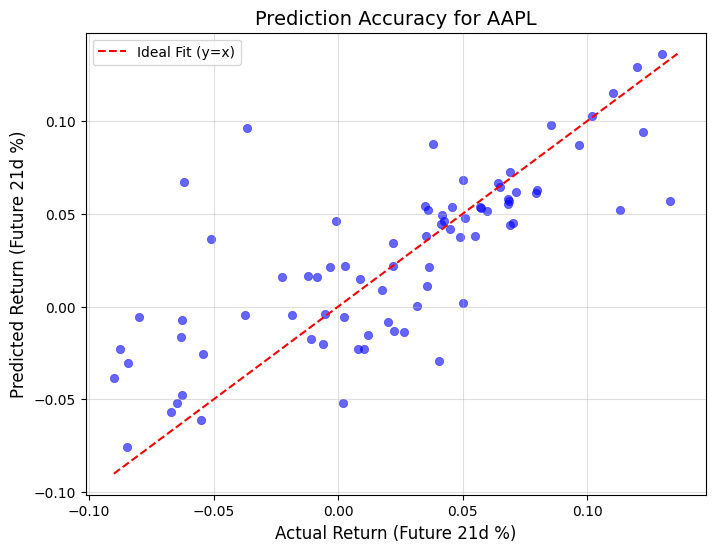

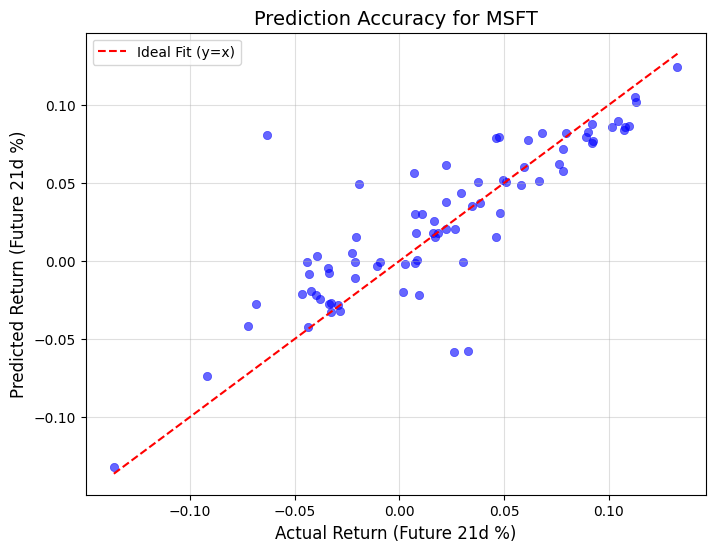

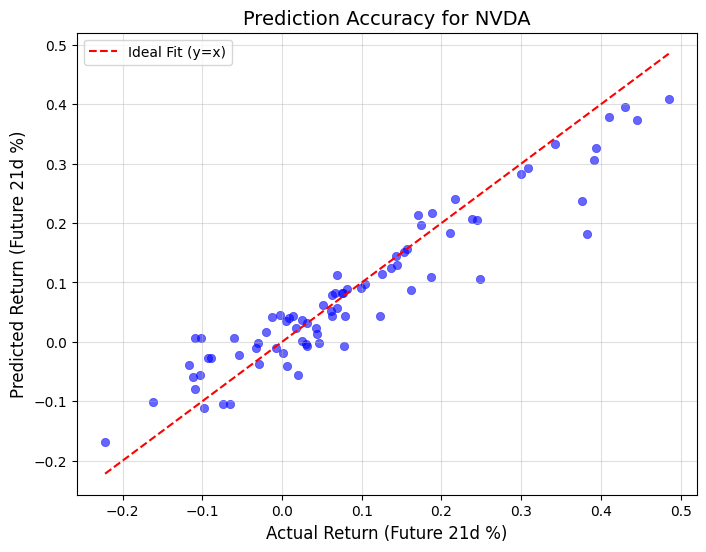

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_prediction_accuracy(stock_predictions):
    """
    Plots a scatter graph for each stock to evaluate prediction accuracy.

    Args:
        stock_predictions (dict): Dictionary with tickers as keys and DataFrames containing predictions and actual values as values.
    """
    for ticker, predictions in stock_predictions.items():
        # Extract actual and predicted returns
        actual = predictions['Actual']
        predicted = predictions['Predicted']

        # Plot scatter graph
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=actual, y=predicted, alpha=0.6, color='blue', edgecolor=None)

        # Add ideal diagonal line
        max_val = max(actual.max(), predicted.max())
        min_val = min(actual.min(), predicted.min())
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y=x)')

        # Add titles and labels
        plt.title(f'Prediction Accuracy for {ticker}', fontsize=14)
        plt.xlabel('Actual Return (Future 21d %)', fontsize=12)
        plt.ylabel('Predicted Return (Future 21d %)', fontsize=12)
        plt.legend()
        plt.grid(alpha=0.4)

        # Show the plot
        plt.show()
data = fetch_data(['AAPL', 'MSFT', 'NVDA'], '2023-01-01', '2024-11-01')
enhanced_data = add_technical_indicators_with_look_forward(data)

# Train models and get predictions for each stock
stock_predictions,stock_models = train_xgboost_per_stock_with_lookforward(enhanced_data)

for ticker, predictions in stock_predictions.items():
    # Sort by the Date index
    stock_predictions[ticker] = predictions.sort_index()

# Display results for each stock
for ticker, predictions in stock_predictions.items():
    print(f"\nPredictions for {ticker}:")
    print(predictions.tail())

plot_prediction_accuracy(stock_predictions)

In [15]:
from sklearn.metrics import mean_squared_error
import pandas as pd

def calculate_mse_for_all_stocks(stock_predictions):
    """
    Calculates the Mean Squared Error (MSE) for each stock model.

    Args:
        stock_predictions (dict): Dictionary with tickers as keys and DataFrames with predicted and actual values as values.

    Returns:
        pd.DataFrame: DataFrame containing tickers and their corresponding MSE, sorted by MSE.
    """
    mse_results = []

    # Calculate MSE for each stock
    for ticker, predictions_df in stock_predictions.items():
        # Ensure the DataFrame has 'Predicted' and 'Actual' columns
        if 'Predicted' in predictions_df and 'Actual' in predictions_df:
            mse = mean_squared_error(predictions_df['Actual'], predictions_df['Predicted'])
            mse_results.append({
                'Ticker': ticker,
                'MSE': mse
            })

    # Convert to DataFrame and sort by MSE
    mse_df = pd.DataFrame(mse_results)
    mse_df = mse_df.sort_values(by='MSE', ascending=True)  # Sort by ascending MSE (lower MSE is better)

    return mse_df
data = fetch_data(['AAPL', 'MSFT', 'NVDA'], '2023-01-01', '2024-11-01')
enhanced_data = add_technical_indicators_with_look_forward(data)

# Train models and get predictions for each stock
stock_predictions,stock_models = train_xgboost_per_stock_with_lookforward(enhanced_data)

for ticker, predictions in stock_predictions.items():
    # Sort by the Date index
    stock_predictions[ticker] = predictions.sort_index()

# Display results for each stock
for ticker, predictions in stock_predictions.items():
    print(f"\nPredictions for {ticker}:")
    print(predictions.tail())

# plot_prediction_accuracy(stock_predictions)
calculate_mse_for_all_stocks(stock_predictions)

[*********************100%***********************]  3 of 3 completed


Training model for stock: AAPL
Training model for stock: MSFT
Training model for stock: NVDA

Predictions for AAPL:
            Predicted    Actual
Date                           
2024-08-30   0.016703 -0.012183
2024-09-04   0.022048  0.021825
2024-09-09   0.034004  0.022000
2024-09-17   0.044175  0.069145
2024-09-20   0.021343  0.036284

Predictions for MSFT:
            Predicted    Actual
Date                           
2024-08-30   0.000861  0.008510
2024-09-04   0.017875  0.018684
2024-09-09   0.020267  0.022158
2024-09-17  -0.042602 -0.043732
2024-09-20  -0.024612 -0.037885

Predictions for NVDA:
            Predicted    Actual
Date                           
2024-08-30   0.016999 -0.019854
2024-09-04   0.155596  0.156671
2024-09-09   0.106193  0.248145
2024-09-17   0.197516  0.174150
2024-09-20   0.207270  0.238879


,Ticker,MSE
1,MSFT,0.000894
0,AAPL,0.001360
2,NVDA,0.002897


In [16]:
from datetime import timedelta

def predict_future_returns(stock_models, stock_predictions, data, days_ahead=21):
    """
    Predicts the return of each stock for the next `days_ahead` days using the most recent data.

    Args:
        stock_models (dict): Dictionary with tickers as keys and trained models as values.
        stock_predictions (dict): Dictionary with tickers as keys and DataFrames containing predictions.
        data (pd.DataFrame): The original dataset containing the stock data.
        days_ahead (int): The number of days ahead to predict (default is 21).

    Returns:
        pd.DataFrame: DataFrame containing the predicted returns for each stock.
    """
    future_predictions = []

    for ticker, model_info in stock_models.items():
        model = model_info['model']

        # Get the most recent data for the stock
        stock_data = data.xs(ticker, level='Ticker').tail(1)  # Get the most recent row for this stock

        # Extract features (ensure that the latest data row is available)
        latest_features = stock_data[['rsi', 'momentum', 'sma_50']].values

        # Make the prediction for the future return (21 days ahead)
        future_return = model.predict(latest_features)

        # Store the prediction along with the date of prediction
        future_predictions.append({
            'Ticker': ticker,
            'Predicted_Future_Return': future_return[0],  # Single value prediction
            'Prediction_Date': stock_data.index[0] + timedelta(days=days_ahead)  # Date 21 days from the latest data
        })

    # Convert to DataFrame
    future_predictions_df = pd.DataFrame(future_predictions)
    future_predictions_df = future_predictions_df.sort_values(by='Predicted_Future_Return', ascending=True)
    return future_predictions_df


In [18]:
# Load the CSV file
import pandas as pd

# Disable the warning
pd.set_option('mode.chained_assignment', None)

df = pd.read_csv('stock_list.csv')

# Convert the 'stocks' column into a list
stocks_list = df['Stocks'].tolist()

data = fetch_data(stocks_list, '2023-01-01', '2024-12-05')
enhanced_data = add_technical_indicators_with_look_forward(data)

# Train models and get predictions for each stock
stock_predictions, stock_models = train_xgboost_per_stock_with_lookforward(enhanced_data)

# Rank models by MSE
mse_df = calculate_mse_for_all_stocks(stock_predictions)
print("Model MSE Rankings:")
mse_df

# plot_prediction_accuracy(stock_predictions)

# Predict future returns for each stock
future_predictions_df = predict_future_returns(stock_models, stock_predictions, enhanced_data)
print("\nFuture Predictions (21 Days Ahead):")
future_predictions_df

[*********************100%***********************]  282 of 282 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRKB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:['WMB']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))


Training model for stock: A
Training model for stock: AAPL
Training model for stock: ABBV
Training model for stock: ACGL
Training model for stock: ADBE
Training model for stock: ADI
Training model for stock: ADP
Training model for stock: ADSK
Training model for stock: AFL
Training model for stock: AIZ
Training model for stock: AJG
Training model for stock: AKAM
Training model for stock: ALNY
Training model for stock: AMAT
Training model for stock: AMD
Training model for stock: AMGN
Training model for stock: AMP
Training model for stock: AMT
Training model for stock: AMZN
Training model for stock: ANET
Training model for stock: ANSS
Training model for stock: AON
Training model for stock: APD
Training model for stock: AVGO
Training model for stock: AVTR
Training model for stock: AXON
Training model for stock: AXP
Training model for stock: BAC
Training model for stock: BALL
Training model for stock: BBY
Training model for stock: BG
Training model for stock: BK
Training model for stock: BK

,Ticker,Predicted_Future_Return,Prediction_Date
60,COIN,-0.234462,2024-12-25
18,AMZN,-0.180809,2024-12-25
81,DT,-0.155091,2024-12-25
267,WBD,-0.154993,2024-12-25
96,FBIN,-0.147628,2024-12-25
...,...,...,...
183,MRNA,0.277734,2024-12-25
253,TWLO,0.282225,2024-12-25
25,AXON,0.377953,2024-12-25
216,PLTR,0.468911,2024-12-25


In [19]:
mse_df

,Ticker,MSE
84,ECL,0.000191
120,HIG,0.000296
64,COST,0.000315
93,EXC,0.000372
179,MMC,0.000388
...,...,...
253,TWLO,0.010728
216,PLTR,0.013483
251,TSLA,0.014369
188,MSTR,0.022082
